# Challenge data SD-TSIA 211 : Yassine NAJI - Nima ALIKHANI

En raison des limitations de google colab, certaines cellules ont été executées sur d'autres notebooks, et leur résultat n'est pas présent. Les conclusions sont néanmoins écrites pour elles.

Pour résumer nos étapes de recherches :
- Le dataset est déséquilibré.
- L'oversampling et le subsampling n'ont pas apporté de résultats concluants.
- La PCA et la selection de variable non plus, peut-être parce que les algorithmes qu'on utilise et qui ont un meilleur score (LGBM) ont déjà une complexité plutot élevé.
- La création de nouvelles features a aidé à améliorer le score.
- Après avoir eu un bon score, rajouter un sample du test avec leur prédiction a aidé à améliorer le score.
- Nous n'avons pas eu le temps de trouver une architecture de deep-learning efficace.
- Nous avons atteint notre score avec LGBM et un paramètrage fin des hyperparamètres.

# Chargement et analyse préliminaire des données


## Préliminaires : imports et installations

In [0]:
#Installation LGBM pour gpu
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile
!pip3 install scikit-learn==0.21.3


Cloning into 'LightGBM'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 17509 (delta 0), reused 2 (delta 0), pack-reused 17505
Receiving objects: 100% (17509/17509), 11.91 MiB | 32.36 MiB/s, done.
Resolving deltas: 100% (12772/12772), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 29.63 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'
/content/LightGBM
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr

In [0]:
#Installation catboost
!pip install catboost

In [0]:
#Installation xgboost gpu
!wget https://s3-us-west-2.amazonaws.com/xgboost-wheels/xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl
!pip uninstall xgboost
!pip install xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl


--2020-04-15 22:02:04--  https://s3-us-west-2.amazonaws.com/xgboost-wheels/xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.232.152
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.232.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16621349 (16M) [binary/octet-stream]
Saving to: ‘xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl.2’

xgboost-0.81-py2.py 100%[===================>]  15.85M  27.0MB/s    in 0.6s    

2020-04-15 22:02:05 (27.0 MB/s) - ‘xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl.2’ saved [16621349/16621349]

Uninstalling xgboost-0.81:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/xgboost-0.81.dist-info/*
    /usr/local/lib/python3.6/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.81
Processing ./xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl


In [0]:
%matplotlib inline
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
import math
import seaborn as sns
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
import lightgbm as lgbm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib
from sklearn.preprocessing import Normalizer


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Chargement des données, à modifier de votre côté ;)
from google.colab import drive
drive.mount('/content/drive')

xtrain = pd.read_csv('/content/drive/My Drive/xtrain_challenge.csv', delimiter=',')
ytrain = pd.read_csv('/content/drive/My Drive/ytrain_challenge.csv', delimiter=',')
xtest = pd.read_csv('/content/drive/My Drive/xtest_challenge.csv', delimiter=',')

train_data = pd.concat([xtrain, ytrain], axis=1)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_data

,qs1,qs2,qs3,qs4,qs5,qs6,qs7,qs8,qs9,qs10,qs11,qs12,qs13,qr1,qr2,qr3,qr4,qr5,qr6,qr7,qr8,qr9,qr10,qr11,qr12,qr13,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,y
0,1.0,0.0,0.0,-3.45,-13.14,1.33,0.27,0.99,2.01,212.61,47.40,0.0,0.00,1.0,0.0,0.0,-2.99,-16.61,1.91,0.16,0.81,0.38,177.85,30.02,0.0,0.00,6190.44,6451.89,7382.84,6075.20,10290.42,6839.45,6782.62,7594.45,6711.65,6664.71,6688.64,1
1,1.0,0.0,0.0,-2.67,-4.88,7.44,0.94,2.03,0.72,271.53,41.95,0.0,0.10,1.0,0.0,0.0,43.33,-22.09,-6.73,3.92,2.38,1.92,194.98,25.12,0.0,0.37,1998.00,2152.79,3329.34,2793.19,2358.42,2454.09,2905.30,2299.96,2434.24,3009.29,2576.67,0
2,1.0,0.0,0.0,2.46,7.30,-9.13,1.83,1.17,0.19,359.26,58.69,0.0,1.00,1.0,0.0,0.0,-4.50,-23.19,6.68,0.08,0.01,0.42,170.83,61.30,0.0,1.00,2141.67,1632.99,1729.66,1791.57,1913.13,1983.23,1819.05,1816.75,1902.28,2899.05,1795.84,0
3,1.0,0.0,0.0,17.31,-5.53,-8.82,1.00,1.87,1.15,283.71,53.40,0.0,1.00,1.0,0.0,0.0,1.40,-6.28,1.69,0.85,0.01,0.61,301.23,59.35,1.0,1.00,2400.46,2367.91,2601.43,2535.50,1940.38,2301.36,2215.60,2708.72,2524.65,3274.52,3233.94,0
4,1.0,0.0,0.0,15.76,7.75,5.65,2.49,1.11,1.56,232.08,25.18,0.0,0.00,1.0,0.0,0.0,-0.71,-13.37,1.12,2.17,0.01,0.90,342.37,48.03,0.0,0.01,1830.43,1715.43,2123.74,2386.98,1028.29,1890.42,2035.30,2013.08,2529.66,2941.38,2288.81,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068499,1.0,0.0,0.0,0.32,-14.24,0.43,1.48,0.41,1.97,255.86,24.47,0.0,0.00,1.0,0.0,0.0,-0.69,-15.89,-2.32,0.83,0.08,0.09,226.20,52.53,0.0,0.00,2668.21,2312.32,2737.24,2575.79,2616.55,2679.98,2141.29,2544.82,2139.45,3520.01,2982.99,0
1068500,1.0,0.0,0.0,3.25,-18.52,-0.31,1.07,0.54,1.00,213.44,27.54,0.0,0.00,1.0,0.0,0.0,-2.10,-1.82,0.22,0.61,0.61,0.04,286.63,42.26,0.0,0.00,2287.09,1938.34,2496.96,2185.43,1974.06,1982.11,1842.32,2066.01,2416.41,3204.54,2125.83,0
1068501,1.0,0.0,0.0,-3.02,-16.83,-6.92,2.87,0.12,0.78,79.19,21.71,0.0,0.98,1.0,0.0,0.0,16.03,-28.72,-7.33,3.13,1.32,0.79,115.56,22.11,0.0,1.00,2142.46,2273.70,2550.68,2930.53,2010.41,2447.65,1546.61,3096.17,2786.21,3105.90,3128.04,0
1068502,1.0,0.0,0.0,-1.79,-6.60,-0.18,0.07,0.22,0.58,435.04,25.42,0.0,1.00,1.0,0.0,0.0,-2.63,-20.23,-3.07,0.40,0.47,0.68,288.86,55.00,0.0,1.00,2290.45,1703.36,1958.47,1876.51,1556.27,1770.74,1554.55,1529.29,2170.51,2749.07,1996.58,0


Comme indiqué dans l'énoncé, il y a 37 features.
Parmis elles, 13 décrivent la première image, 13 la seconde et 11 qui décrivent la relation entre les deux images.

Il y a 1 068 504 couples d'images dans le dataset de train.

## Analyse de la distribution des observations


Essayons d'y voir plus clair en affichant la distribution des données.

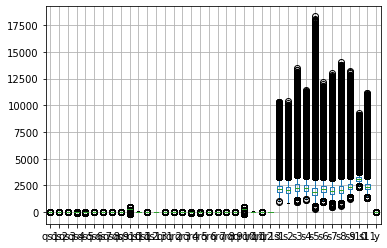

In [0]:
train_data.boxplot()

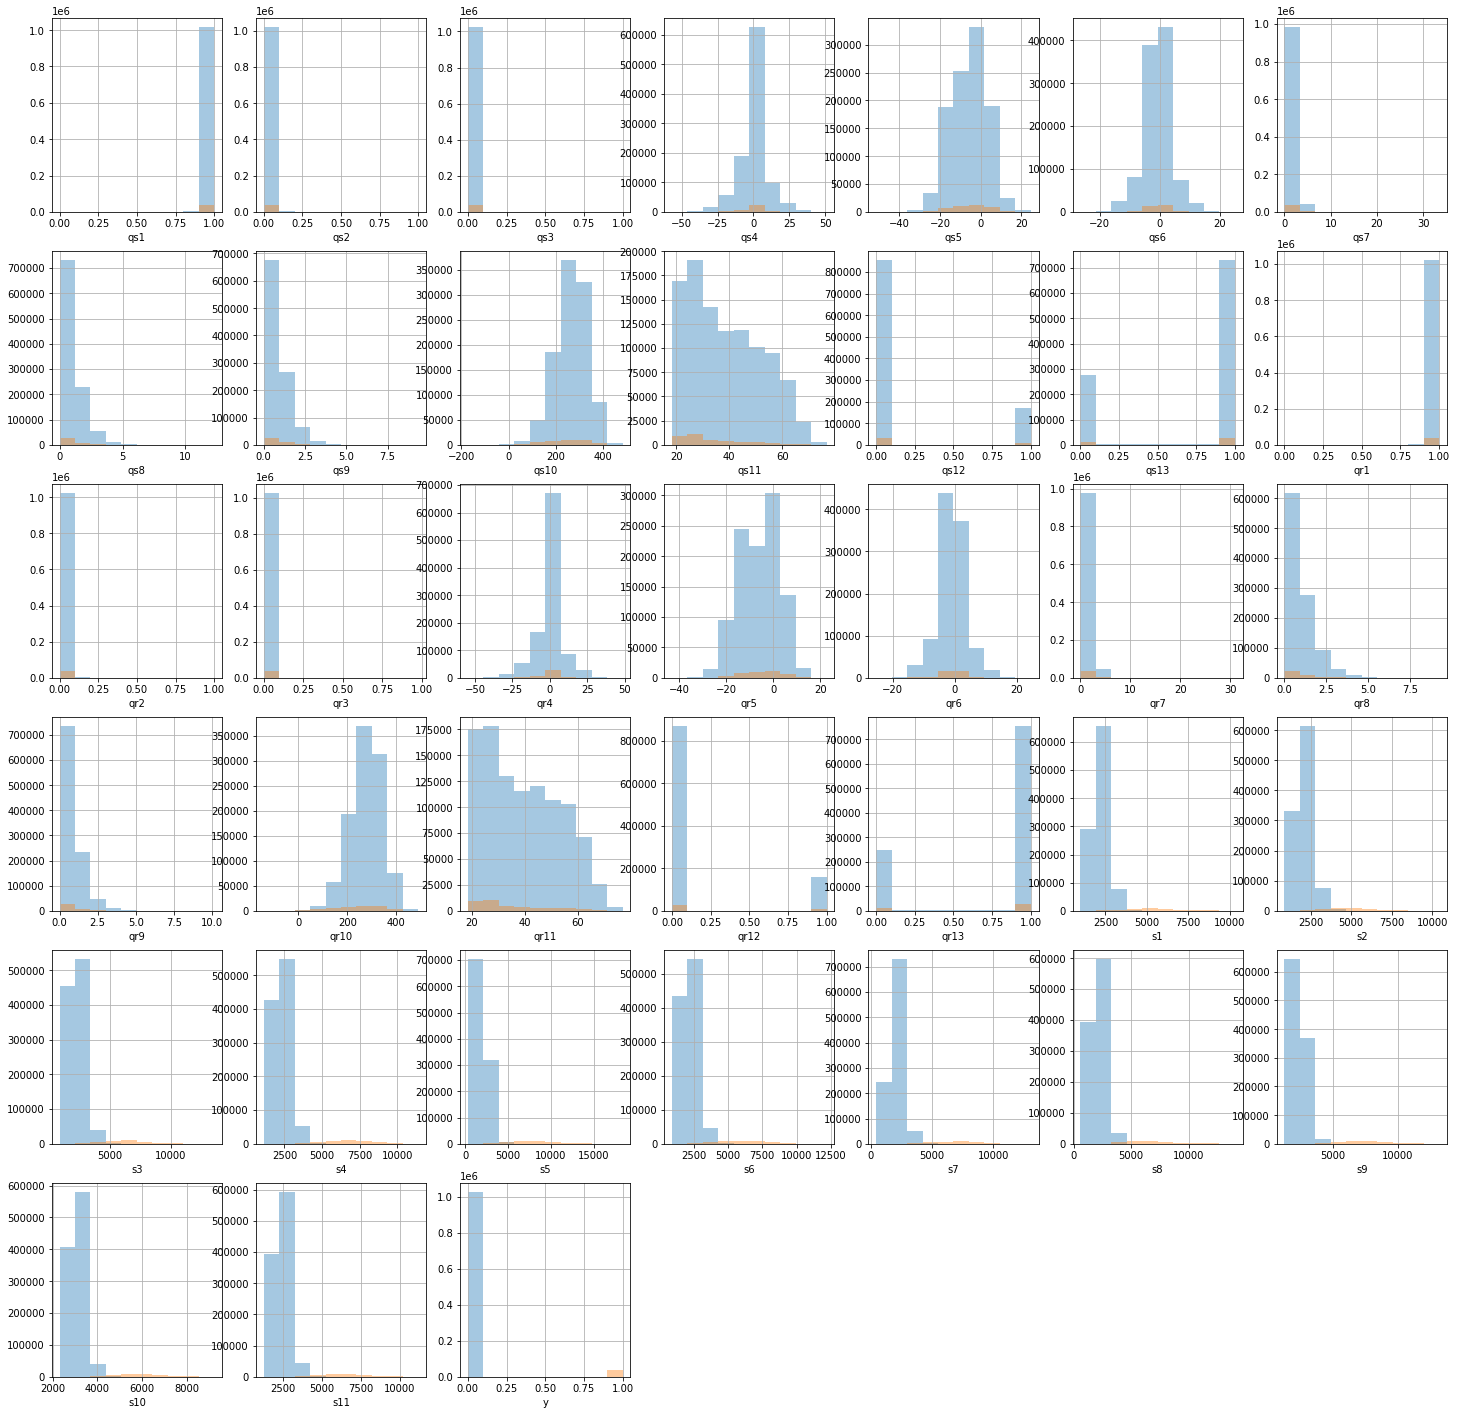

In [0]:
Xtrain = train_data
for i in range(38):
  col = Xtrain.columns[i]
  ax=plt.subplot(6, 7, i+1)
  Xtrain.groupby('y')[col].hist(alpha=0.4,ax=ax,range=[Xtrain[col].min(),Xtrain[col].max()],figsize=(25, 25))
  ax.set_xlabel(col)
    

Les données ne sont pas toutes représentées dans les mêmes proportions au niveau de y (0 et 1).

Les features scores distingues le mieux les deux classes, on s'attend à ce qu'ils soient les plus importantes pour la classification.

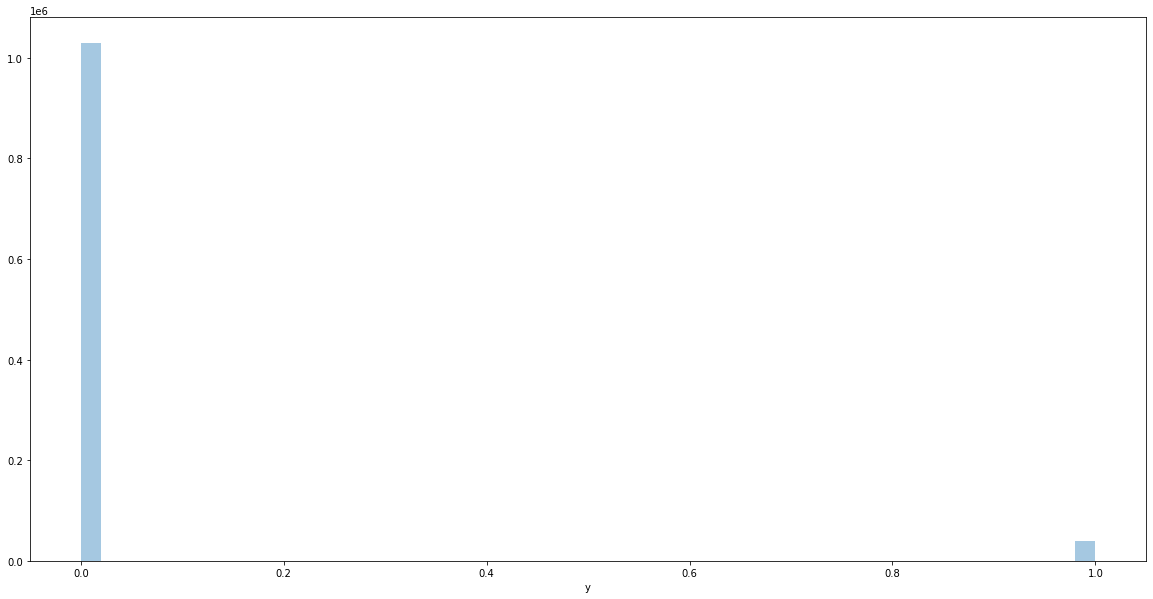

In [0]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.distplot(ytrain, axlabel="y", kde=False)

In [0]:
print(f"Nombre de 0 : {np.count_nonzero(ytrain['y'].values==0)}\nNombre de 1 : {np.count_nonzero(ytrain['y'].values==1)}")
print(f"0/1 : {np.count_nonzero(ytrain['y'].values==0)/np.count_nonzero(ytrain['y'].values==1)}\n1/0 : {np.count_nonzero(ytrain['y'].values==1)/np.count_nonzero(ytrain['y'].values==0)}")

Nombre de 0 : 1028911
Nombre de 1 : 39593
0/1 : 25.98719470613492
1/0 : 0.03848049053805431


Voici une des particularités du dataset : il est **déséquilibré**. Il y a bien plus de cas négatifs (0) que de cas positifs (1).

C'est une situation qui peut tout à fait arriver dans la vie réelle. Imaginons la detection d'attaque sur un système informatique, la plupart des cas seront négatifs dans les données d'entrainement.
Cela peut être problématique. Durant l'apprentissage, un algorithme peut carrément ignoré les cas positifs en se disant qu'il garde une très bonne accuracy (justesse en francais).

Pour rappel, la **justesse** est le nombre de prédictions correcte sur le nombre total de prédictions. C'est la métrique utilisée dans l'évaluation pour le challange.


Nous pouvons à priori définir 3 solutions pour combattre le problème :
- Ne rien faire sur le dataset et, quand le modèle le permet, mettre des poids plus élevés aux observations positives.
- **Downsampling**, prendre moins de 0 pour qu'il y en ait autant que de 1.
- **Upsampling**, prendre autant d'obeservations positives que d'observations négatives. On peut prendre plusieurs fois les mêmes observations positives (tirage avec remise), ou utiliser des techniques pour en créer de nouvelles.


## Quid du dataset de test ?

Sondons si le dataset de test a les mêmes proportions en soumettant un fichier avec uniquement des 0

In [0]:
yvalid = np.zeros((3318296,))
np.savetxt('/content/drive/My Drive/test_0.csv', yvalid, fmt = '%1.0d', delimiter=',')

On obtiens un score de .964844004272, ce qui indique que le déséquilibre est aussi présent dans ce dataset de test.

## Analyse de la matrice de correlation

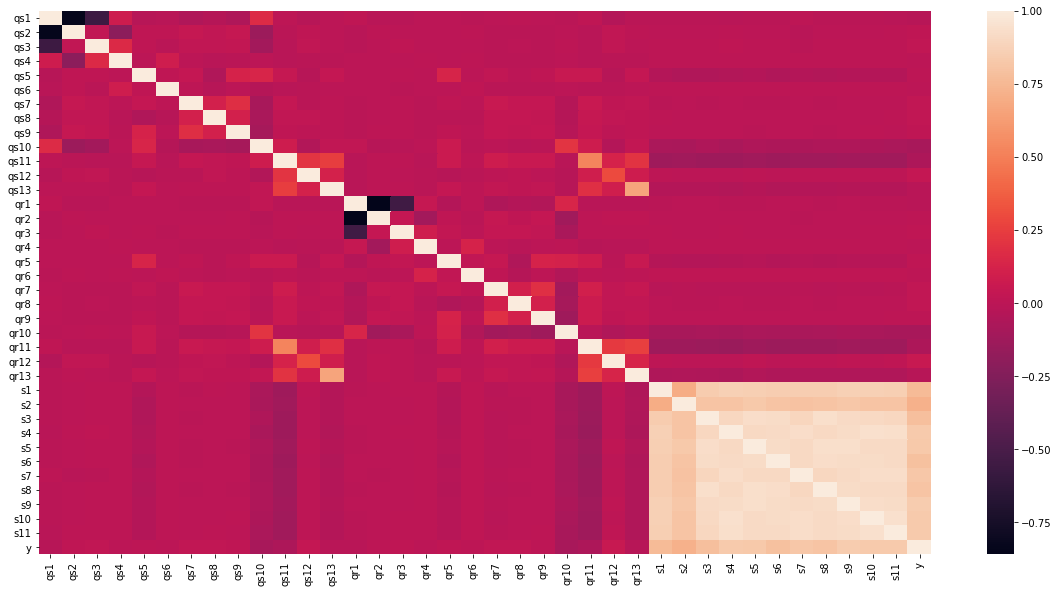

In [0]:
sns.heatmap(train_data.corr())


On peut tirer deux conclusions :
- Les "matching scores" sont pertinentes dans notre tache de classification car ils sont hautement corrélés avec notre variable y.
- Les matching scores sont également corrélées entre elle de manière forte.
Intuitivement, cela peut être une mauvaise chose à cause du bruit que cela ajoute à notre modèle. Cependant, cela pourait aussi être une bonne chose car la relation entre ces differentes features peut être utile pour le modèle.

## Exploratory Data Analysis

Il y a deux types de features. Les qualities de des images, sous forme de 13 paires qr et qs, permettent de décrire les images avec 13 attributs.
Les score de matching, surement crées avec les qualities, nous indiquent la similarité entre les deux images.

### Features des qualities des images

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


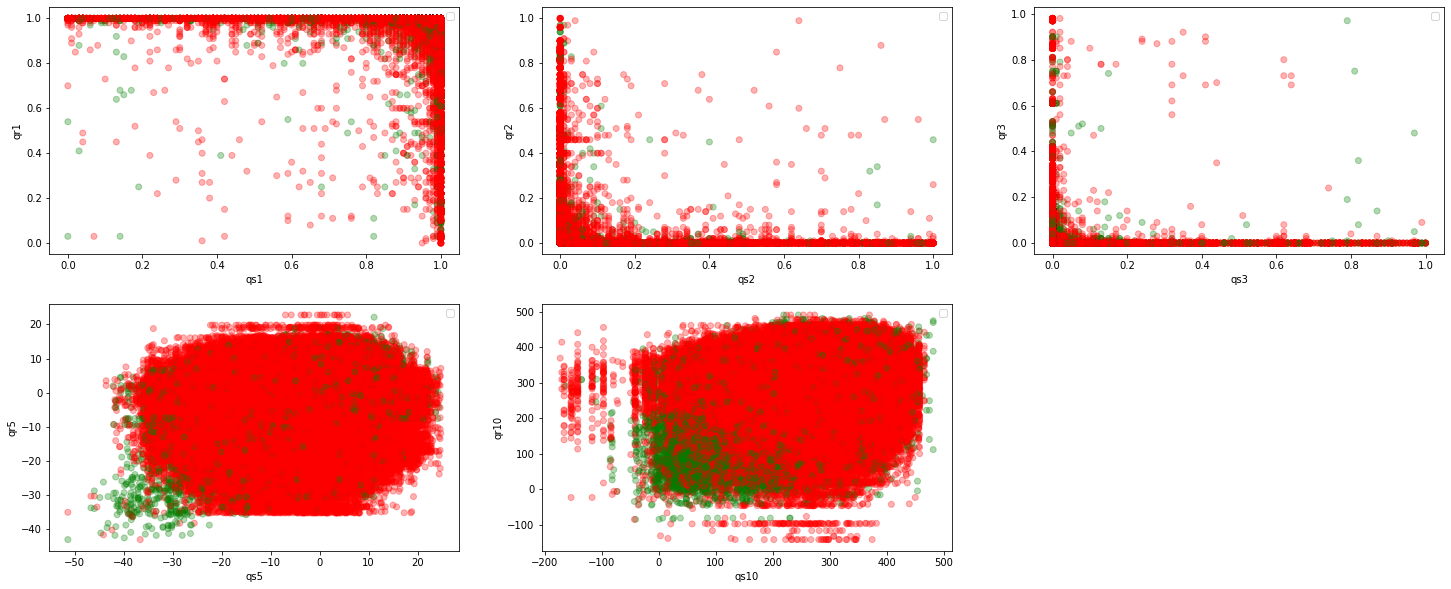

In [0]:
X = train_data
colors = ['red','green']

for i in list(range(1, 4))+[5, 10]:
  col1 = f'qs{i}'
  col2 = f'qr{i}'
  ax=plt.subplot(2, 3, (list(range(1, 4))+[5, 10]).index(i)+1)
  #sns.scatterplot(X[col1], X[col2], hue=ytrain['y'], alpha=0.3, ax=ax, legend=False)
  ax.scatter(X[col1], X[col2], c=ytrain['y'], cmap=matplotlib.colors.ListedColormap(colors), alpha=0.3)
  ax.set_xlabel(col1)
  ax.set_ylabel(col2)
  ax.figure.set_size_inches((25, 10))
  ax.legend()


Tentons de normaliser :

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


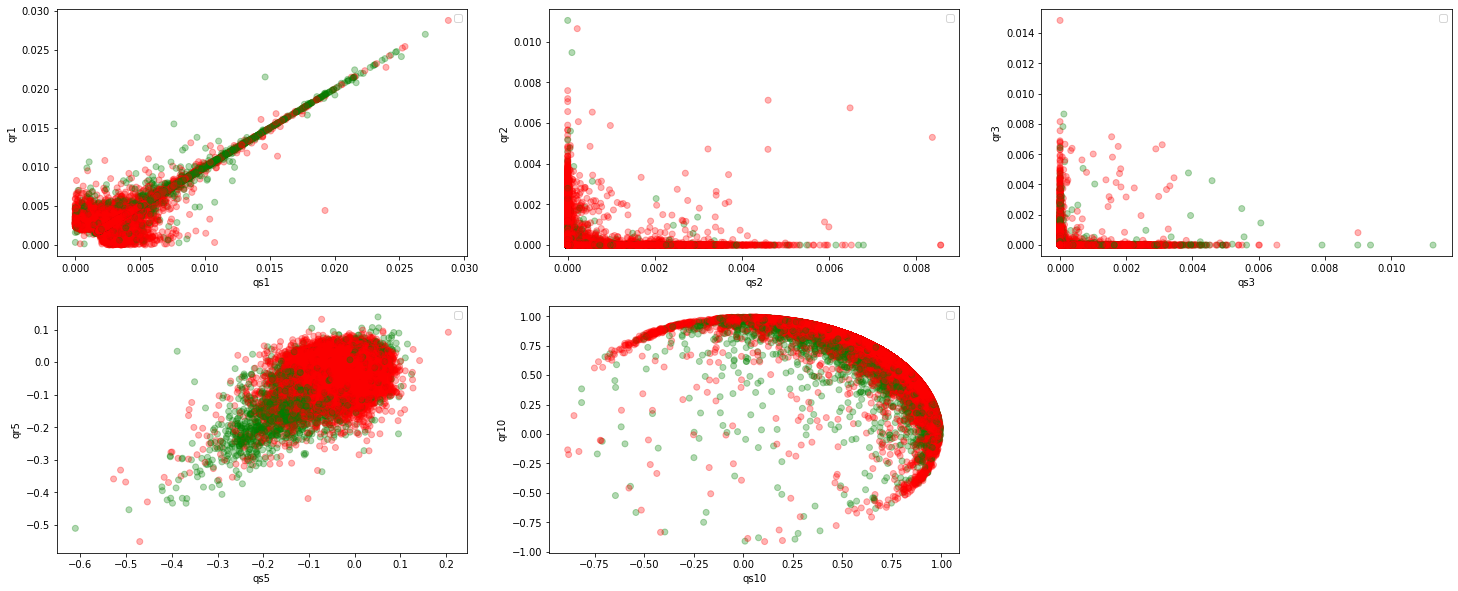

In [0]:
cols = [f'qr{i}' for i in range(1, 14)] + [f'qs{i}' for i in range(1, 14)]
X = pd.DataFrame(Normalizer().fit_transform(xtrain[cols]), columns=xtrain[cols].columns) 
colors = ['red','green']

for i in list(range(1, 4))+[5, 10]:
  col1 = f'qs{i}'
  col2 = f'qr{i}'
  ax=plt.subplot(2, 3, (list(range(1, ))+[5, 10]).index(i)+1)
  #sns.scatterplot(X[col1], X[col2], hue=ytrain['y'], alpha=0.3, ax=ax, legend=False)
  ax.scatter(X[col1], X[col2], c=ytrain['y'], cmap=matplotlib.colors.ListedColormap(colors), alpha=0.3)
  ax.set_xlabel(col1)
  ax.set_ylabel(col2)
  ax.figure.set_size_inches((25, 10))
  ax.legend()


Les qualités 5 et 10 semblent pertinentes . Voyons voir si l'on ne peut pas crée une nouvelle feature à partir de ces deux là.

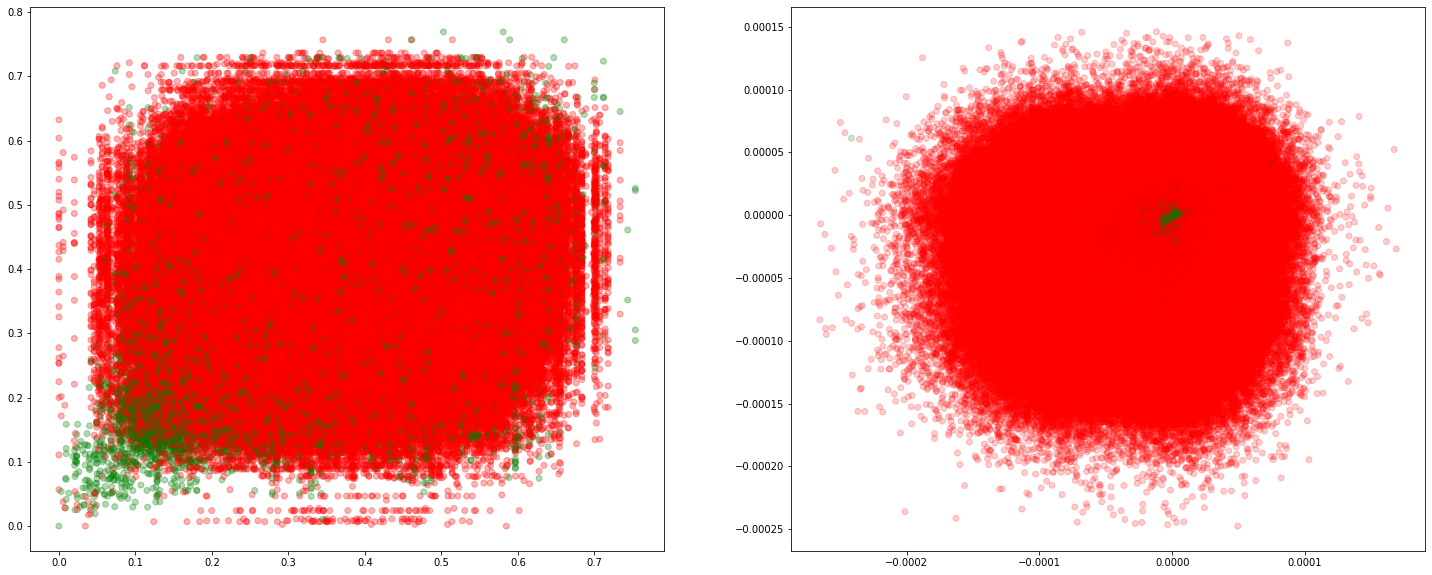

In [0]:
colors = ['red','green']
ax=plt.subplot(1, 2, 1)
Xstd = pd.DataFrame(MinMaxScaler().fit_transform(xtrain), columns=xtrain.columns)
ax.scatter(Xstd['qr10']*Xstd['qr5'], Xstd['qs10']*Xstd['qs5'], c=ytrain['y'], cmap=matplotlib.colors.ListedColormap(colors), alpha=0.3)

ax=plt.subplot(1, 2, 2)
Xstd = pd.C(Normalizer().fit_transform(xtrain), columns=xtrain.columns)
ax.scatter(Xstd['qr10']*Xstd['qr5'], Xstd['qs10']*Xstd['qs5'], c=ytrain['y'], cmap=matplotlib.colors.ListedColormap(colors), alpha=0.2)
ax.figure.set_size_inches((25, 10))


En normalisant chaque échantillon, on semble obtenir en multipliant les qualités 5 et 10 de chaque image une feature qui sépare modéremment bien nos échantillons.

In [0]:
Xstd = pd.DataFrame(Normalizer().fit_transform(xtrain), columns=xtrain.columns)

xtrain["new_qr5-10"] = Xstd['qr10']*Xstd['qr5']
xtrain["new_qs5-10"] = Xstd['qs10']*Xstd['qs5']

On obtient d'autres features pertinantes à partir de l'annalyse des distributions des qualités 1 et 11:

In [0]:
xtrain['new_q11'] = (Xstd['qr11']).abs()+(Xstd['qs11']).abs()
xtrain['new_q10'] = (Xstd['qr10']).abs()+(Xstd['qs10']).abs()
xtrain['new_q1'] =  Xstd['qr1']*Xstd['qs1']

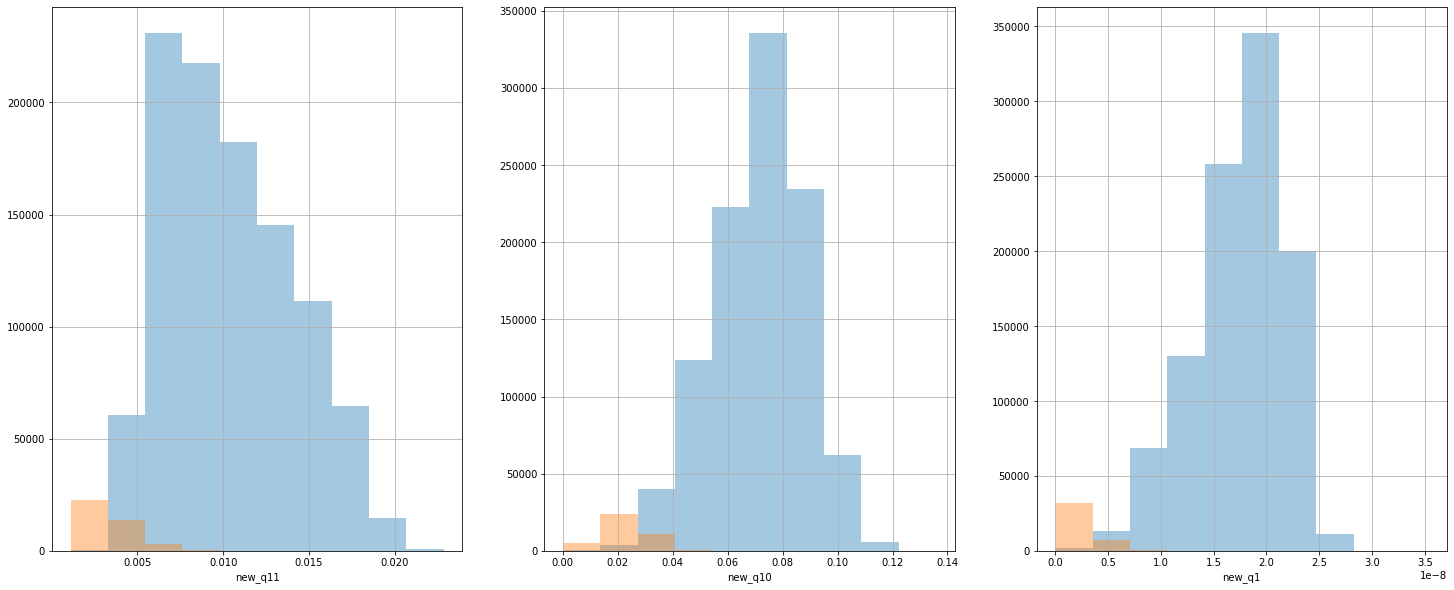

In [0]:
data_train = pd.concat([xtrain,ytrain],axis=1)
L=['new_q11','new_q10','new_q1']
i=1
for col in L:
  ax=plt.subplot(1, 3, i)
  data_train.groupby('y')[col].hist(alpha=0.4,ax=ax,range=[data_train[col].min(),data_train[col].max()],figsize=(25, 10))
  ax.set_xlabel(col)
  i+=1





On arrive à avoir une bonne distinction des classes.

###Features matching scores

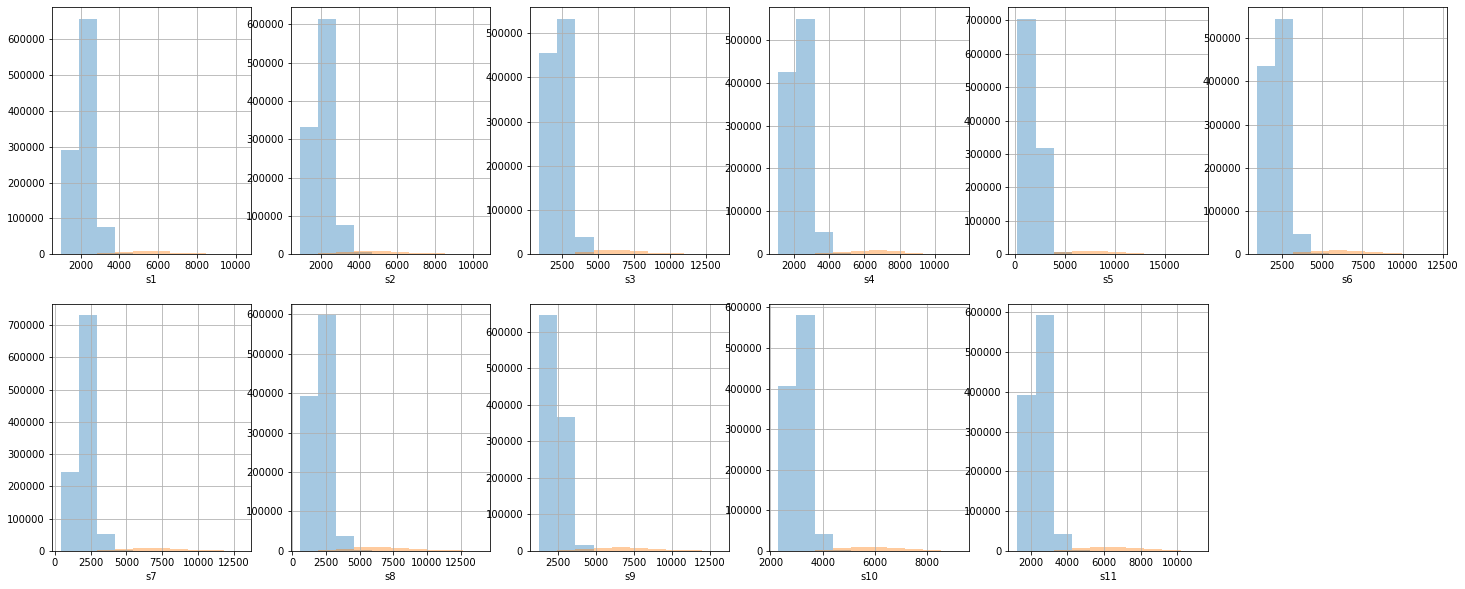

In [0]:
Xtrain = train_data
for i in range(1, 12):
  col1 = f's{i}'
  ax=plt.subplot(2, 6, i)
  Xtrain.groupby('y')[col1].hist(alpha=0.4,ax=ax,range=[Xtrain[col1].min(),Xtrain[col1].max()],figsize=(25, 10))
  ax.set_xlabel(col1)


Plus ces matching scores sont haut, plus la probabilité que les images soient identiques est élevé.

On va regarder en prenant l'exemple de s3 si une transformation ne pourait pas  mieux séparer les classes ou tout du moins avoir des distributions qui se chevauchent moins et plus proches de distribution gaussiennes.

y
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: s3, dtype: object

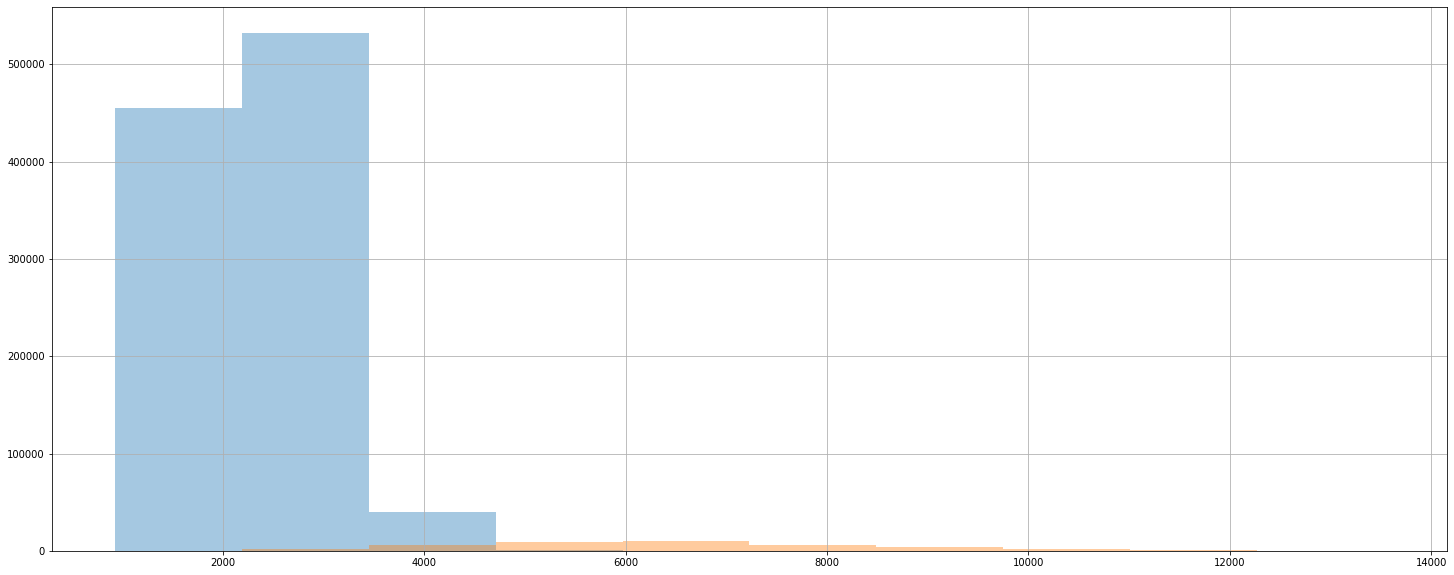

In [0]:
col1 = 's3'
Xtrain.groupby('y')[col1].hist(alpha=0.4,range=[Xtrain[col1].min(),Xtrain[col1].max()],figsize=(25, 10))


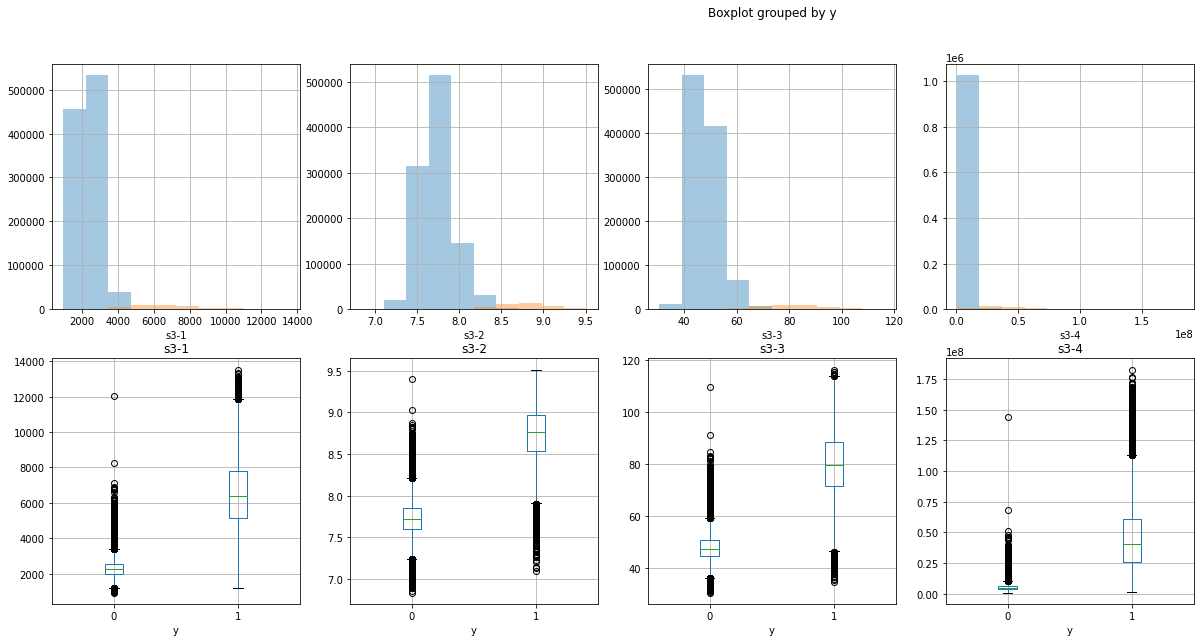

In [0]:
functions = [np.array, np.log1p, np.sqrt, np.square]
i=1
for function in functions:
  col1 = f's3-{i}'
  Xtrain[f's3-{i}'] = function(Xtrain['s3'])
  ax=plt.subplot(2, 5, i)
  ax2=plt.subplot(2, 5, i+5)
  Xtrain.groupby('y')[col1].hist(alpha=0.4,ax=ax,range=[Xtrain[col1].min(),Xtrain[col1].max()],figsize=(25, 10))
  Xtrain.boxplot(by='y', column=col1, grid='True', ax=ax2)
  ax.set_xlabel(col1)
  i+=1

La transformation avec le log1p (log (x + 1)) semble satisfaisante.
- D'une part, la distrbution bleue (cas négatifs) est plus étalée.
- D'autre part, les boites à moustache (boxplot) se chevauchent moins, et l'une n'est pas intégralement contenue dans l'autre (cas normal et avec square)

In [0]:
for i in range(1, 12):
  col1 = f's{i}'
  new_col1 = col1 + "_log1p"
  xtrain[new_col1] = np.log1p(xtrain[col1])

In [0]:
plt.rcParams['figure.figsize'] = [20, 10]


Maintenant, on va essayé de créer une nouvelle feature qui agrège tous ces scores. En effet, les combiner peut peut-être nous apporter plus d'informations.
On va tester :
- norme infini (max)
- norme 11 (11 scores)
- moyenne
- produit

<function <lambda> at 0x7fb8f0416f28> 1
<function <lambda> at 0x7fb8f0416158> 2
<function mean at 0x7fb92124ed08> 3
<function prod at 0x7fb92124e510> 4


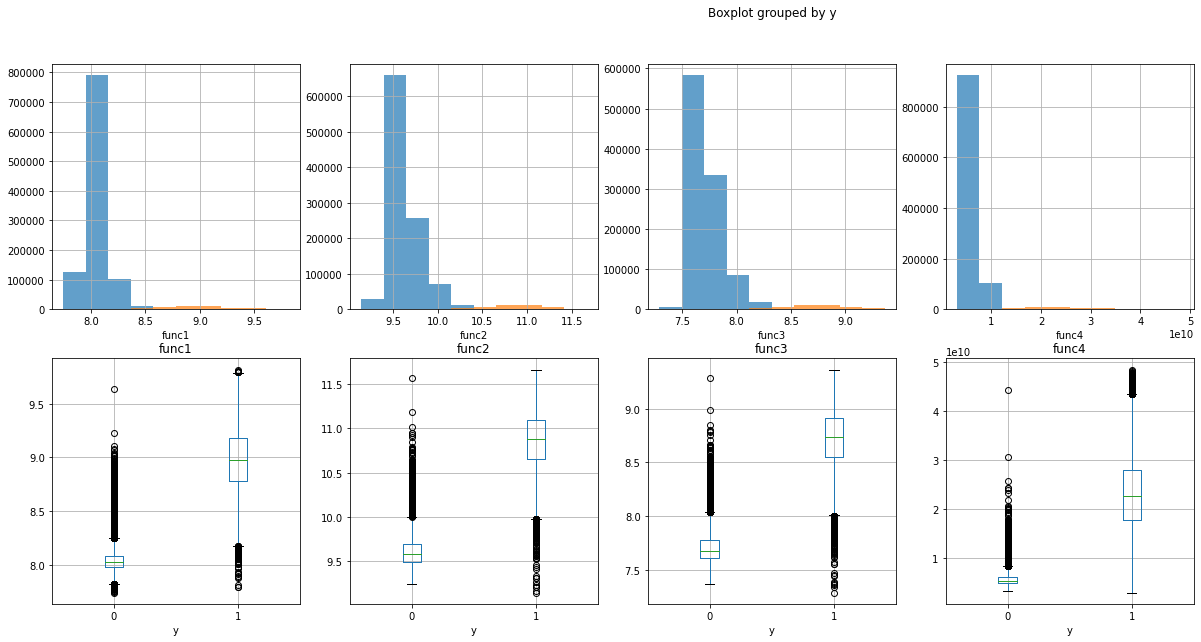

In [0]:
from scipy.stats import hmean, gmean

cols = [f's{i}_log1p' for i in range(1, 12)]
functions = [lambda x, axis : np.linalg.norm(x, ord=np.inf, axis=axis), lambda x, axis : np.linalg.norm(x, ord=11, axis=axis) , np.mean, np.prod]
i=1
Xtrain = pd.concat([xtrain, ytrain], axis=1)
for function in functions:
  print(function, i)
  Xtrain[f'func{i}'] = function(Xtrain[cols], axis=1)
  ax=plt.subplot(2, 5, i)
  ax2=plt.subplot(2, 5, i+5)
  Xtrain.groupby('y')[f'func{i}'].hist(alpha=0.7,ax=ax,range=[Xtrain[f'func{i}'].min(),Xtrain[f'func{i}'].max()],figsize=(25, 10))
  Xtrain.boxplot(by='y', column=f'func{i}', grid='True', ax=ax2)
  ax.set_xlabel(f'func{i}')
  i+=1

La norme infinie et la norme p séparent plutot bien les classes tout en ayant une distribution bleue plus ou moins symétrique.

On prends ces des nouvelles features ainsi que le deuxième maximum ("norme inf -2")


In [0]:
cols = [f's{i}_log1p' for i in range(1, 12)]

xtrain["norme_inf"] = np.linalg.norm(xtrain[cols], ord=np.inf, axis=1)
xtrain["norme_p"] = np.linalg.norm(xtrain[cols], ord=11, axis=1)
xtrain["norme_inf-2"] = np.sort(xtrain[cols], axis=1)[:,-2]

# Préliminaire de la partie machine learning

Plusieurs options s'offre à nous quant aux features.
- Faire de la selection de variable pour ne garder que celles qui sont les plus pertinentes.
- Faire une PCA.
- Ne rien faire.



## Variable selection

Nous pouvons faire de la selection de variable. Comment les choisir ?
Nous allons utilisé XGBoost. Durant l'apprentissage à l'aide de cet algorithme, un classement des variables va être généré. Nous pourrons nous appuyer sur celui-ci.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size=0.20, random_state=42)
X_train_lite, X_test_lite, y_train_lite, y_test_lite = train_test_split(xtrain, ytrain, train_size=20000, test_size=20000, random_state=42)

###XGBoost

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


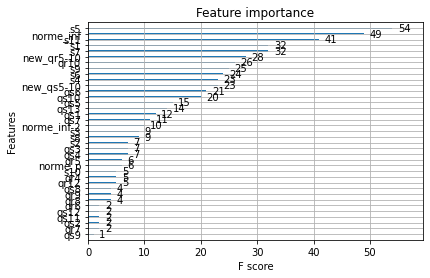

In [0]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_lite, y_train_lite)
xgb.plot_importance(xgboost_model)

In [0]:
accuracy_score(y_test_lite, xgboost_model.predict(X_test_lite))

0.99745

In [0]:
selected_cols = [elem[0] for elem in list(filter(lambda elem: elem[1]>=10, xgboost_model.get_booster().get_fscore().items()))]

On prends toutes les colonnes avec un F-score supérieur ou égal à 10.

In [0]:
xtrain_vs = xtrain[selected_cols]
xtrain_vs = xtrain[selected_cols]

### Pipeline

Pour faciliter toutes les opérations, on met en place une pipeline pour extraire les colonnes, et normaliser.

In [0]:
class ColumnExtractor(object):

    def transform(self, X):
        cols = X[selected_cols]
        return cols

    def fit(self, X, y=None):
        return self

class GetDataFrame(object):

    def transform(self, X):
        return pd.DataFrame(X, columns=selected_cols)

    def fit(self, X, y=None):
        return self


In [0]:
variable_selec_pipeline = Pipeline(steps=[
    ('reduce_dim', ColumnExtractor()),           
    ('scaler', StandardScaler()),
    ('reduce_dim2', GetDataFrame())
    ])

## PCA

#### Utilisation des librairies

Testons une PCA. Elle nous permet d'avoir moins de composantes (réduction de dimension) et d'éviter le fléau de la dimension.

Par contre, ces nouvelles features ne seront pas interprétables ...

In [0]:
xtrain_std = StandardScaler().fit_transform(xtrain.copy())


In [0]:
pca = PCA()
principalComponents = pca.fit_transform(xtrain_std)

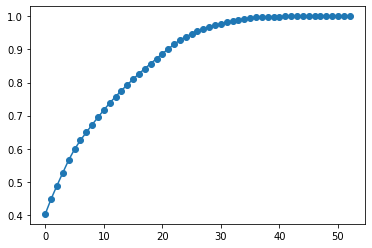

In [0]:
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), marker="o")

Sur ce graphe, on peut voir le pourcentage de la variance totale en fonction du nombre de composante.

On voit que vers 25 composantes on a entre 90 et 100% de la variance, et que la pente de la courbe devient très petite. Les dernières composantes ne semblent donc pas nécessaires.

On choisit un nombre de composante correspondant à 95% de la variance totale.

In [0]:
pca = PCA(n_components = 0.95)
principalComponents = pca.fit_transform(xtrain_std)
principalDf = pd.DataFrame(data = principalComponents
             , columns = [f'principal component {i}' for i in range(len(pca.explained_variance_ratio_))])


In [0]:
xtrain_pca = principalDf.copy()
pca = PCA()
xtrain_pca = StandardScaler().fit_transform(xtrain_pca.copy())
xtrain_pca

array([[ 4.83517132, -0.70678762,  0.24181131, ...,  0.18364362,
         1.85778329, -1.18697629],
       [ 0.24158046, -0.83511231,  0.3898536 , ..., -1.19698915,
        -1.65649678, -0.75901914],
       [-0.71052555,  0.43752235, -0.41609684, ..., -0.10304027,
         0.85603046,  0.16828423],
       ...,
       [ 0.24827632, -0.83699863,  0.87781462, ..., -1.28345989,
        -0.48145461,  0.22700305],
       [-0.74701902, -1.13872143, -0.50961745, ...,  0.88648337,
         1.84326056,  1.69776325],
       [-0.50366551, -0.69237769,  0.11208031, ...,  0.02994394,
         2.08880063, -1.15590514]])

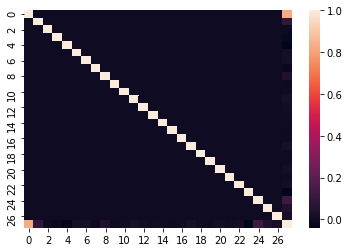

In [0]:
heatmap_df = pd.concat([pd.DataFrame(xtrain_pca), ytrain], axis=1)
sns.heatmap(heatmap_df.corr())


#### Pipeline

Voila une nouvelle pipeline pour simplifier les opérations : elle enchaine normalisation et PCA.

In [0]:
class GetDataFrame(object):

    def transform(self, X):
        return pd.DataFrame(X, columns=[f'Principal comp {n}' for n in range(X.shape[1])])

    def fit(self, X, y=None):
        return self


In [0]:
pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components = 0.95), GetDataFrame())

## Scaler pipeline

Pipeline pour normaliser.

Attention : le StandardScaler de scikitlearn renvoit un numpy array, qui n'est plus un panda DataFrame. 

In [0]:
temp_col_names = xtrain.columns

class GetColNames(object):

    def transform(self, X):
        global temp_col_names
        temp_col_names = X.columns
        return X

    def fit(self, X, y=None):
        return self

class GetDataFrame2(object):

    def transform(self, X):
        return pd.DataFrame(X, columns=temp_col_names)

    def fit(self, X, y=None):
        return self


In [0]:
scaling_pipeline = make_pipeline(GetColNames(), StandardScaler(), GetDataFrame2())

## Résumé des pipelines de traitement de features

Les pipelines sont :
- **variable_selec_pipeline** : variable selection de XGBoost
- **pca_pipeline** : PCA
- **scaling_pipeline** : Scaling


# Premier essai : ne pas combattre le déséquilibre

*gardez ceci en tête : sera talentueux celui qui vaincra sans combattre*  

Sun Tzu

## Feature modifications : aucune (pas de PCA / variable selection)

In [0]:
#Take a subsample with less rows, but with the same proportion of y
tampon2 = scaling_pipeline.fit_transform(xtrain.copy())
tampon = pd.concat([tampon2, ytrain], axis=1)

tampon, aa = train_test_split(tampon, train_size=15000, test_size=15000,random_state=42, stratify=tampon['y'])

Xlite = tampon.drop(labels='y', axis=1)
Ylite = tampon['y']

Xlitetest = aa.drop(labels='y', axis=1)
Ylitetest = aa['y']


### -- SVM and RandomForest Search Grids

Implémentation d'une gridsearch pour le SVM et les Randomforest

In [0]:
from scipy.spatial.distance import pdist, squareform

def get_gamma(xt):
  #Trick to get a correct gamma ?
  #https://blog.smola.org/post/940859888/easy-kernel-width-choice
  a = []
  for i in range(1000):
    sample = xt.iloc[np.random.choice(len(xt), size=2, replace=False)]
    distances = pdist(sample.values, metric='euclidean')
    dist_matrix = squareform(distances)
    a.append(dist_matrix[0, 1])
  return np.median(a)

In [0]:
def svc_param_selection(X, y):
    #gam = get_gamma(pd.DataFrame(X))
    Cs = [0.01, 0.1, 1, 10, 100]
    gammas = [0.01, 0.1, 1, 10]
    param_grid = [
      {'C': Cs, 'kernel': ['linear'], 'class_weight':['balanced', None]},
      {'C': Cs, 'gamma': gammas, 'kernel': ['rbf'], 'class_weight':['balanced', None]},
    ]
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=3, verbose=10)
    grid_search.fit(X, y)
    return grid_search.best_params_,grid_search.best_score_

In [0]:
def rf_param_selection(X, y):
    y = y.values.ravel()

    rfc = RandomForestClassifier(n_jobs=-1, max_features= 'sqrt' ,n_estimators=50, oob_score = True) 
    param_grid = {
        'n_estimators': [100, 300, 500],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    grid_search.fit(X, y)
    return grid_search.best_params_,grid_search.best_score_

### SVM

On essaie d'utiliser un classifieur à base de SVM.

In [0]:
svc_param_selection(Xlite, Ylite)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] C=0.01, class_weight=balanced, kernel=linear ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, class_weight=balanced, kernel=linear, score=0.996, total=   0.4s
[CV] C=0.01, class_weight=balanced, kernel=linear ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  C=0.01, class_weight=balanced, kernel=linear, score=0.993, total=   0.3s
[CV] C=0.01, class_weight=balanced, kernel=linear ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  C=0.01, class_weight=balanced, kernel=linear, score=0.995, total=   0.3s
[CV] C=0.01, class_weight=None, kernel=linear ........................
[CV]  C=0.01, class_weight=None, kernel=linear, score=0.997, total=   0.1s
[CV] C=0.01, class_weight=None, kernel=linear ........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV]  C=0.01, class_weight=None, kernel=linear, score=0.998, total=   0.1s
[CV] C=0.01, class_weight=None, kernel=linear ........................
[CV]  C=0.01, class_weight=None, kernel=linear, score=0.998, total=   0.1s
[CV] C=0.1, class_weight=balanced, kernel=linear .....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.4s remaining:    0.0s


[CV]  C=0.1, class_weight=balanced, kernel=linear, score=0.995, total=   0.3s
[CV] C=0.1, class_weight=balanced, kernel=linear .....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.7s remaining:    0.0s


[CV]  C=0.1, class_weight=balanced, kernel=linear, score=0.994, total=   0.2s
[CV] C=0.1, class_weight=balanced, kernel=linear .....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


[CV]  C=0.1, class_weight=balanced, kernel=linear, score=0.996, total=   0.2s
[CV] C=0.1, class_weight=None, kernel=linear .........................
[CV]  C=0.1, class_weight=None, kernel=linear, score=0.997, total=   0.2s
[CV] C=0.1, class_weight=None, kernel=linear .........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s


[CV]  C=0.1, class_weight=None, kernel=linear, score=0.997, total=   0.1s
[CV] C=0.1, class_weight=None, kernel=linear .........................
[CV]  C=0.1, class_weight=None, kernel=linear, score=0.997, total=   0.1s
[CV] C=1, class_weight=balanced, kernel=linear .......................
[CV]  C=1, class_weight=balanced, kernel=linear, score=0.994, total=   0.3s
[CV] C=1, class_weight=balanced, kernel=linear .......................
[CV]  C=1, class_weight=balanced, kernel=linear, score=0.994, total=   0.2s
[CV] C=1, class_weight=balanced, kernel=linear .......................
[CV]  C=1, class_weight=balanced, kernel=linear, score=0.996, total=   0.2s
[CV] C=1, class_weight=None, kernel=linear ...........................
[CV]  C=1, class_weight=None, kernel=linear, score=0.997, total=   0.2s
[CV] C=1, class_weight=None, kernel=linear ...........................
[CV]  C=1, class_weight=None, kernel=linear, score=0.997, total=   0.2s
[CV] C=1, class_weight=None, kernel=linear ...........

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 38.4min finished


({'C': 0.01, 'class_weight': None, 'kernel': 'linear'}, 0.9978000000000001)

In [0]:
svc2 = SVC(kernel="linear", C=0.01, random_state=42)
model2 = svc2.fit(Xlite, Ylite)
score = model2.score(Xlitetest, Ylitetest)
score

0.9976666666666667

### Random Forest

Esayons une random forest

In [0]:
rf_param_selection(Xlite, Ylite)

({'max_features': 'log2', 'n_estimators': 500}, 0.9973333333333333)

### XGBoost

In [0]:
xgb_model = XGBClassifier XGBClassifier(tree_method = "gpu_hist", predictor = "gpu_predictor", verbosity = 3, objective = "binary:logistic",learning_rate=0.11,max_depth=10, min_child_weight=3, n_estimators = 1500)
scores = cross_validate(xgb_model, Xlite, Ylite, cv=3)['test_score'].mean()
print(scores)


### LGBM

LightGBM est un algorithme d'apprentissage basé sur des arbres (un peu comme une RandomForest), mais les combinaisons d'arbres sont réalisées au fur et à mesure et non à la toute fin.

 - On effectue un grid search pour séléctionner les valeurs des paramètres les plus importants : num_leaves et learning_rate, les valeurs optimales trouvées : num_estimators=1500 , learning_rate=0.08

 - On s'est rendu compte que la valeur optimale du paramètre max_depth (profondeur de l'arbre de décision) croît en augumentant le nombre de données d'entrainement. Ainsi on a constaté que pour un entrainement sur 100% des données d'entrainement une profondeur de 8 de l'arbre de decision est optimale.

 - Concernant le paramètre boosting_type, on a constaté que le type 'goss' (Gradient-based One-Side Sampling) permettait de reduire considèrablement le temps de calcul, cela est du au fait 'goss' ne garde que les échantillions ayant une grande valeur de gradient (de la fonction de perte), et effectue un un échantillonage aleatoire sur le reste. Ce type de boosting permet également d'éviter l'overfit.

In [0]:
bst = lgbm.LGBMClassifier(objective = 'binary', num_leaves=71,learning_rate=0.08, n_estimators=1500, boosting_type='goss')
bst.fit(Xlite, Ylite)
preds2 = bst.predict(Xlitet)
accuracy = accuracy_score(Ylitet, preds2)
print(accuracy)

0.9990968689898503


In [0]:
lgbm.plot_importance(bst,figsize=(25, 10))

In [0]:
lgbm.plot_tree(bst)

Nous avons tester la mise en place d'un learning rate adaptatif avec lgbm, mais sans résultat superieur.

In [0]:
bst = lgbm.LGBMClassifier(objective = 'binary', num_leaves=71,learning_rate=0.08, n_estimators=1500, boosting_type='goss')

def learning_rate_power_0997(current_iter):
    base_learning_rate = 0.08
    min_learning_rate = 0.01
    lr = base_learning_rate  * np.power(.995, current_iter)
    return max(lr, min_learning_rate)

bst1.fit(X_train, y_train, 
            eval_set=[(X_test,y_test)],
            eval_names= ['valid'], early_stopping_rounds=600, callbacks = [lgbm.reset_parameter(learning_rate=learning_rate_power_0997)])
preds = bst1.predict(X_test)
accuracy = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat, accuracy)

### CatBoostClassifier

Le principe de catboost est très similaire à celui de lgbm, nous n'allons pas entrer dans les détails.

Les résultats avec catboost sont légèrement moins bons qu'avec LGBM.

In [0]:
model1 = CatBoostClassifier(
  iterations=1500,
  learning_rate=0.005,
  task_type='GPU',
  use_best_model=True,
  metric_period=10,
  depth=12,
  l2_leaf_reg=10,
  border_count=128,
  custom_metric=['Accuracy']
)


model1.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=1
)  


preds3 = model1.predict(Xlitet)
accuracy = accuracy_score(Ylitet, preds3)
print(accuracy)



0.9987599496492763


In [0]:
model.feature_importances_


array([ 0.17990067,  0.20881033,  0.23165964,  2.55733774,  8.93815256,
        2.05225779,  1.42753148,  1.02288259,  0.78190282, 10.66185624,
        1.56191146,  0.91333882,  1.00243632,  0.1195179 ,  0.1845721 ,
        0.22372273,  2.7372052 ,  5.98994324,  2.10749397,  1.56018486,
        0.65464138,  0.81248448, 12.44366047,  0.93470265,  0.86200685,
        1.3845829 ,  4.35888972,  3.14413503,  1.5182552 ,  5.0856438 ,
        6.44802058,  3.75616906,  1.98208001,  1.13329327,  7.46411627,
        1.50822364,  2.04647623])

### Tripleboost : LGBM * XGB * CatBoost

*Il faut prier une fois avant de partir en guerre, deux fois avant de s'aventurer en mer, trois fois avant de soumettre le csv*

Il serait interessant de combiner nos trois meilleur algorithmes en les fesant voter.

En effet on a constaté que les 3 algorithmes se trompent en grandes majorité (+70%) sur les memes échatillons ce qui un inconvenient pour notre méthode. Ainsi, on peut espèrer dimininuer l'erreur d'au plus 30%.

In [0]:
# #code pour le vote


# model1 = lgbm.LGBMClassifier(objective = 'binary', num_leaves=71,learning_rate=0.08, n_estimators=1500, boosting_type='goss')
# model1.fit(Xlite, Ylite)
# pred1 = model1.predict(Xlitet)


# model2 =  XGBClassifier(tree_method = "gpu_hist", predictor = "gpu_predictor", verbosity = 3, objective = "binary:logistic",learning_rate=0.11,max_depth=10, min_child_weight=3, n_estimators = 1500)
# model2.fit(Xlite, Ylite)
# pred2 = model2.predict(Xlitet)


# model3 = CatBoostClassifier(iterations=1500, 
#                            task_type="GPU",
#                            devices='0:1',
#                            depth=10)
# model3.fit(Xlite, Ylite)
# pred3 = model3.predict(Xlitet)



# ytest_ =[]
# for i in range(len(pred1)):
#   if(pred1[i][0]+pred2[i][0]+pred3[i][0] > 1.5):
#     ytest_.append(1)
#   else:
#     ytest_.append(0)

# accuracy = accuracy_score(Ylitet, ytest_)
# print(accuracy)


## Fit par rapport aux échatillons test

 - L'un des facteurs principaux d'amélioration de l'accuracy score est l'augumentation la taille de la base de données d'entrainement . Ainsi, on a constaté qu'il serait intéressant d'entrainer le modèle sur toute la base de données d'entrainement et rajouter x% de données de test avec y_test qui corresond au meilleur score qu'on a réalisé à l'instant(0.99860) en espérant avoir un nombre limité d'erreurs de classification dans les x% sélectionnés.

 - On en a déduit une méthode itérative qui consiste à mettre à jour y_test à chaque fois qu'on obtient un nouveau meilleur score.

 -En combinant cette méthode avec d'autres téchniques (ajouts de nouvelles features , système de vote...), nous avions été capable d'augementer progressivement notre score.

 - On a commencé par appliquer cette méthode avec 20% d'echantillons test et on a augumenté cette proportion au fur et à mesure que notre score augumente jusqu'à atteindre les 50%. On s'est limité à cette proportion car au delà de celle ci les modèles reproduisent quasiment les mêmes accuracy scores ou un peu moins.


In [0]:

#code pour la soumission

# ytest = pd.read_csv('/content/drive/My Drive/ytest_student.csv', delimiter=',',header=None)
# ytest.columns = ['y']

# data_test = pd.concat([xtest,ytest],axis=1)

# data_test_20 = data_test.sample(frac=0.2)

# xtrain_extra = data_test_20.drop(labels='y',axis=1)
# ytrain_extra = data_test_20['y']

# xtrain_extra.reset_index(drop=True, inplace=True)
# ytrain_extra.reset_index(drop=True, inplace=True)

# new_xtrain = pd.concat([xtrain,xtrain_extra],axis=0)
# new_ytrain =  pd.concat([ytrain,ytrain_extra],axis=0)



# bst = lgbm.LGBMClassifier(objective = 'binary', num_leaves=71,learning_rate=0.08, n_estimators=1500, boosting_type='goss')
# bst.fit(new_xtrain, new_ytrain)
# preds2 = bst.predict(xtest)

#np.savetxt('/content/drive/My Drive/ytest_student_1.csv', preds2, fmt = '%1.0d', delimiter=',')



### Fit sur xtrain+%xtest & Tiple boost

Le choix des x% du xtest s'effectue de manière aléatoire vu qu'on n'a pas d'informations qui nous permettent de faire un choix adéquat des données à séléctionner, et il se peut qu'on obtient une base de données avec un taux élevé d'erreurs. Pour contourner ce problème, on entraine $E\left(\frac{100}{x}\right)$ (qui doit être impaire)  modèles sur la base de données d'entrainement concatenée à chaque fois avec l'un des x% du dataset test et on les fait voter. Cela permet d'avoir une plus lente mais sûre évolution de score .

In [0]:
#code pour la soumission 

# ytest = pd.read_csv('/content/drive/My Drive/ytest_student.csv', delimiter=',',header=None)
# ytest.columns = ['y']

#x,xtrain_extra1,y,ytrain_extra1 = train_test_split(xtest, ytest,stratify=ytest, test_size = 0.3)

#xtrain_extra3,xtrain_extra2,ytrain_extra3,ytrain_extra2 = train_test_split(x, y,stratify=y, test_size = 0.5)





# model1 = lgbm.LGBMClassifier(objective = 'binary', num_leaves=71,learning_rate=0.08, n_estimators=1500, boosting_type='goss')
# model1.fit(xtrain_extra1, ytrain_extra1)
# pred1 = model1.predict(xtest)


# model2 = lgbm.LGBMClassifier(objective = 'binary', num_leaves=71,learning_rate=0.07, n_estimators=1600, boosting_type='goss')
# model2.fit(xtrain_extra2, ytrain_extra2)
# pred2 = model2.predict(xtest)


# model3 = lgbm.LGBMClassifier(objective = 'binary', num_leaves=71,learning_rate=0.05, n_estimators=1700, boosting_type='goss')
# model3.fit(xtrain_extra3, xtrain_extra3)
# pred3 = model3.predict(xtest)



# ytest_ =[]
# for i in range(len(pred1)):
#   if(pred1[i][0]+pred2[i][0]+pred3[i][0] > 1.5):
#     ytest_.append(1)
#   else:
#     ytest_.append(0)

#np.savetxt('/content/drive/My Drive/ytest_student_2.csv', ytest_, fmt = '%1.0d', delimiter=',')



## Inversion des qualités qr et qs

D'après la symétrie des graphes de distibutions de qr en fonction de qs, ces qualités sont apparemment les mêmes pour les deux images. Ainsi en inversant leurs ordres ont obtient 2 fois plus d'échatillons: 

In [0]:
# l1 = ['qs1','qs2','qs3','qs4', 'qs5', 'qs6', 'qs7', 'qs8', 'qs9', 'qs10','qs11','qs12','qs13']
# l2 =['qr1','qr2','qr3','qr4', 'qr5', 'qr6', 'qr7', 'qr8', 'qr9', 'qr10','qr11','qr12','qr13']




# xtrain_extension1 = xtrain.copy()
# xtrain_extension1[l1]=xtrain[l2]
# xtrain_extension1[l2]=xtrain[l1]


# xtest_extension1 = xtest.copy()
# xtest_extension1[l1]=xtest[l2]
# xtest_extension1[l2]=xtest[l1]




# xtest_ex = pd.concat([xtest,xtest_extension1],axis=0)
# xtrain_ex = pd.concat([xtrain,xtrain_extension1],axis=0)



Cependant, nous n'avons pas eu le temps de proprement tester cette méthode

## Feature modifications : PCA

On réalise les mêmes choses que précédemment mais en appliquant une pca. Malheureusement, les résultats ne sont pas au rendez-vous.

In [0]:
#Take a subsample with less rows, but with the same proportion of y
tampon2 = pca_pipeline.fit_transform(xtrain)
tampon = pd.concat([tampon2, ytrain], axis=1)


tampon, aa = train_test_split(tampon, train_size=0.8, random_state=42, stratify=tampon['y'])

Xlite = tampon.drop(labels='y', axis=1)
Ylite = tampon['y']

Xlitet = aa.drop(labels='y', axis=1)
Ylitet = aa['y']


### SVM

In [0]:
svc_param_selection(Xlite, Ylite)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] C=0.01, class_weight=balanced, kernel=linear ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


### Random Forest

In [0]:
rf_param_selection(Xlite, Ylite)

### XGBoost

In [0]:
xgb_model =  XGBClassifier(tree_method = "gpu_hist", predictor = "gpu_predictor", verbosity = 3, objective = "binary:logistic",learning_rate=0.11,max_depth=10, min_child_weight=3, n_estimators = 1500)
scores = cross_validate(xgb_model, Xlite, Ylite, cv=5)['test_score'].mean()
print(scores)


0.9863000000000002


### LGBM

In [0]:
bst = lgbm.LGBMClassifier(objective = 'binary',learning_rate=0.07,num_leaves=71,n_estimators=2000,boosting_type='goss')
scores = cross_validate(bst, Xlite, Ylite, cv=3)['test_score'].mean()
print(scores)

0.990400089799022


In [0]:
bst = lgbm.LGBMClassifier(objective = 'binary', boosting_type='dart')
scores = cross_validate(bst, Xlite, Ylite, cv=3)['test_score'].mean()
print(scores)

0.9897000197920213


### CatBoostClassifier

In [0]:
model = CatBoostClassifier(iterations=1500, 
                           task_type="GPU",
                           devices='0:1',
                           depth=10)
model.fit(Xlite,
          Ylite,
          verbose=False)
preds = model.predict(Xlitet)
accuracy = accuracy_score(Ylitet, preds)
print(accuracy)



0.9980018811329848


## Feature modifications : variable selection

En faisant de la selection de variable, nous n'avons toujours pas de meilleurs résultats que si on n'avait rien fait aux features

In [0]:
#Take a subsample with less rows, but with the same proportion of y
tampon2 = variable_selec_pipeline.fit_transform(xtrain)
tampon = pd.concat([tampon2, ytrain], axis=1)


tampon, aa = train_test_split(tampon, train_size=0.7, random_state=42, stratify=tampon['y'])

Xlite = tampon.drop(labels='y', axis=1)
Ylite = tampon['y']

Xlitet = aa.drop(labels='y', axis=1)
Ylitet = aa['y']


### SVM

In [0]:
svc_param_selection(X_train, y_train)

({'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'},
 0.9982000599580054)

### Random Forest

In [0]:
rf_param_selection(Xlite, Ylite)

({'max_features': 'auto', 'n_estimators': 100}, 0.9926)

### XGBoost

In [0]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.01, gamma=1, colsample_bytree=0.9)
scores = cross_validate(xgb_model, Xlite, Ylite, cv=5)['test_score'].mean()
print(scores)


0.9970999999999999


In [0]:
from sklearn.metrics import accuracy_score

xgb_model = XGBClassifier()
xgb_model.fit(X_train, Y_train)
y_valid = xgb_model.predict(X_test)
predictions = [round(value) for value in y_valid]
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print(accuracy)


0.998175023085178


### LGBM

In [0]:
bst = lgbm.LGBMClassifier(objective = 'binary',learning_rate=0.07,num_leaves=71,n_estimators=2000,boosting_type='goss')
scores = cross_validate(bst, Xlite, Ylite, cv=5)['test_score'].mean()
print(scores)

0.99824


In [0]:
bst = lgbm.LGBMClassifier(objective = 'binary', boosting_type='dart')
scores = cross_validate(bst, Xlite, Ylite, cv=5)['test_score'].mean()
print(scores)

0.997969993199662


In [0]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(Ylite),
                                                 Ylite)
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [0]:
bst = lgbm.LGBMClassifier(objective = 'binary', boosting_type='goss', class_weight = class_weights)
scores = cross_validate(bst, Xlite, Ylite, cv=5)['test_score'].mean()
print(scores)
y_pred = cross_val_predict(bst, Xlite, Ylite, cv=5)
conf_mat = confusion_matrix(Ylite, y_pred)
(conf_mat)


0.9980100000000001


array([[96165,   130],
       [   69,  3636]])

In [0]:
bst = lgbm.LGBMClassifier(objective = 'binary', boosting_type='goss')
scores = cross_validate(bst, Xlite, Ylite, cv=5)['test_score'].mean()
print(scores)
y_pred = cross_val_predict(bst, Xlite, Ylite, cv=5)
conf_mat = confusion_matrix(Ylite, y_pred)
(conf_mat)


0.9981199999999999


array([[96222,    73],
       [  115,  3590]])

### CatBoostClassifier

In [0]:
model = CatBoostClassifier(iterations=1500, 
                           task_type="GPU",
                           devices='0:1',
                           depth=10)
model.fit(Xlite,
          Ylite,
          verbose=False)
preds = model.predict(Xlitet)
accuracy = accuracy_score(Ylitet, preds)
print(accuracy)



0.9985181811375378


# Deuxième essai : subsampling

*Dans les choses profondes, c'est toujours le petit nombre qui est le plus perspicace ; la majorité, elle, ne s'entend qu'aux évidences.*

Giacomo Leopardi

Dans cette partie, on fait pareil que dans la partie précédant mais en enlevant des cas négatifs pour qu'il y en ait autant que de cas positifs.

Nous n'obtenons pas de meilleurs résultats non plus

In [0]:
y_1 = ytrain.loc[ytrain['y'] == 1]
y_0 = ytrain.loc[ytrain['y'] == 0].iloc[0:len(y_1)]

x_1 = xtrain.loc[y_1.index, :]
x_0 = xtrain.loc[y_0.index, :]

xtrain_sb = x_0.append(x_1)
ytrain_sb = y_0.append(y_1)

In [0]:
temp_merge = pd.concat([xtrain_sb, ytrain_sb], axis=1)
temp_merge = temp_merge.sample(frac=0.01, random_state=42)

xtrain_sb_lite, ytrain_sb_lite = temp_merge.iloc[:,:-1], temp_merge.iloc[:,-1]

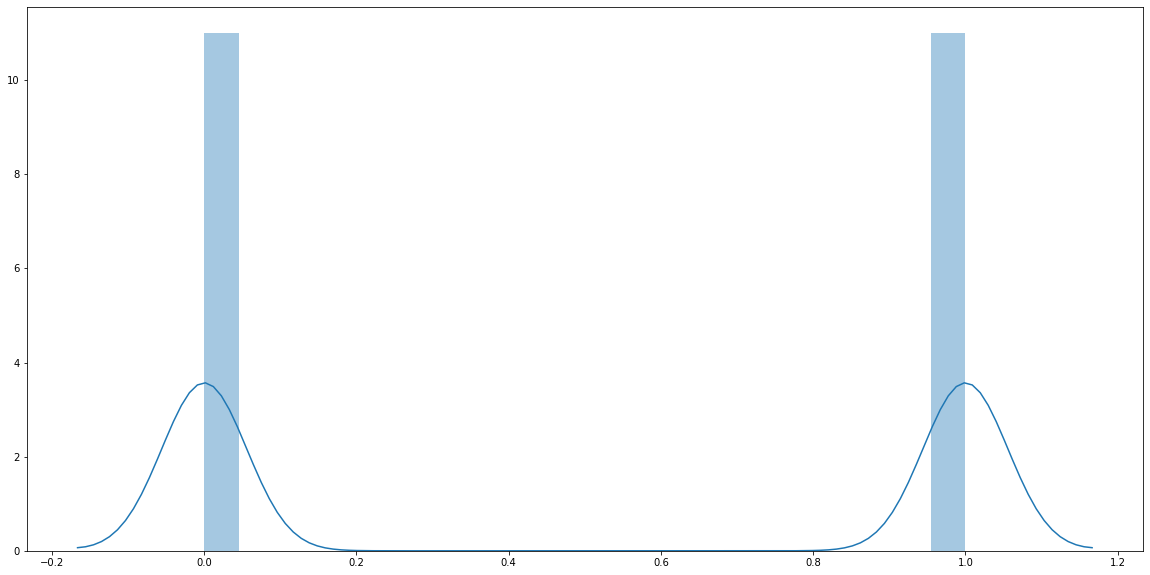

In [0]:
sns.distplot(ytrain_sb)

## Feature modifs : aucune

In [0]:
#Take a subsample with less rows, but with the same proportion of y
tampon = pd.concat([xtrain_sb_lite, ytrain_sb_lite], axis=1)

tampon, aa = train_test_split(tampon, train_size=0.4, random_state=42)

Xlite = tampon.drop(labels='y', axis=1)
Ylite = tampon['y']

Xlitet = aa.drop(labels='y', axis=1)
Ylitet = aa['y']


### CatBoostClassifier

In [0]:
it = [1000, 1200, 1500]
dd = [8, 10]
model = CatBoostClassifier(iterations=2000, 
                           task_type="GPU",
                           depth=10,
                           verbose=False)
param_grid = {'iterations': it, 'depth': dd}
grid_search = GridSearchCV(model, param_grid, cv=3, verbose=10)
grid_search.fit(Xlite, Ylite)
print(grid_search.best_params_,grid_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] depth=8, iterations=1000 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ depth=8, iterations=1000, score=0.972, total= 1.8min
[CV] depth=8, iterations=1000 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV] ............ depth=8, iterations=1000, score=1.000, total= 1.9min
[CV] depth=8, iterations=1000 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s


[CV] ............ depth=8, iterations=1000, score=0.981, total= 1.8min
[CV] depth=8, iterations=1200 ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.5min remaining:    0.0s


[CV] ............ depth=8, iterations=1200, score=0.972, total= 2.1min
[CV] depth=8, iterations=1200 ........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.6min remaining:    0.0s


[CV] ............ depth=8, iterations=1200, score=1.000, total= 2.2min
[CV] depth=8, iterations=1200 ........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.8min remaining:    0.0s


[CV] ............ depth=8, iterations=1200, score=0.981, total= 2.2min
[CV] depth=8, iterations=1500 ........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 12.0min remaining:    0.0s


[CV] ............ depth=8, iterations=1500, score=0.972, total= 2.7min
[CV] depth=8, iterations=1500 ........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 14.7min remaining:    0.0s


[CV] ............ depth=8, iterations=1500, score=1.000, total= 2.8min
[CV] depth=8, iterations=1500 ........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 17.5min remaining:    0.0s


[CV] ............ depth=8, iterations=1500, score=0.981, total= 2.8min
[CV] depth=10, iterations=1000 .......................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 20.3min remaining:    0.0s


KeyboardInterrupt: ignored

In [0]:
model = CatBoostClassifier(iterations=1000, 
                           task_type="GPU",
                           depth=10)
model.fit(Xlite,
          Ylite,
          verbose=False)
preds = model.predict(Xlitet)
accuracy = accuracy_score(Ylitet, preds)
print(accuracy)



0.9915966386554622


### Autres

In [0]:
svc_param_selection(X_train, y_train)

({'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'},
 0.992399959852014)

In [0]:
rf_param_selection(X_train, y_train)

({'max_features': 'log2', 'n_estimators': 100}, 0.9926)

In [0]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.01, gamma=1, colsample_bytree=0.8)
scores = cross_validate(xgb_model, X_train, y_train, cv=5)['test_score'].mean()
print(scores)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9898


In [0]:
xtrain_sb_vs = pd.DataFrame(xtrain_sb)[['qr10', 'qs10', 'qr5', 'qs5', 's1','s2','s3','s4','s5','s6','s7', 's8', 's9','s10','s11']]
scaler = StandardScaler()
xtrain_sb_vs = scaler.fit_transform(xtrain_sb_vs.copy())


In [0]:
X_train, X_test, y_train, y_test = train_test_split(xtrain_sb_vs, ytrain_sb, train_size=10000, test_size=10000, random_state=42)

In [0]:
svc_param_selection(X_train, y_train)

({'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'},
 0.9951000798940122)

In [0]:
rf_param_selection(X_train, y_train)

({'max_features': 'log2', 'n_estimators': 100}, 0.9926999999999999)

In [0]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.01, gamma=1, colsample_bytree=0.8)
scores = cross_validate(xgb_model, X_train, y_train, cv=5)['test_score'].mean()
print(scores)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9902000000000001


## Feature modifications : PCA

In [0]:
#Take a subsample with less rows, but with the same proportion of y
tampon2 = pca_pipeline.fit_transform(xtrain_sb_lite)
tampon = pd.concat([tampon2, ytrain_sb_lite], axis=1)


tampon, aa = train_test_split(tampon, train_size=0.8, random_state=42, stratify=tampon['y'])

Xlite = tampon.drop(labels='y', axis=1)
Ylite = tampon['y']

Xlitet = aa.drop(labels='y', axis=1)
Ylitet = aa['y']


### CatBoostClassifier

In [0]:
model = CatBoostClassifier(iterations=1500, 
                           task_type="GPU",
                           devices='0:1',
                           depth=10)
model.fit(Xlite,
          Ylite,
          verbose=False)
preds = model.predict(Xlitet)
accuracy = accuracy_score(Ylitet, preds)
print(accuracy)



# Troisième essai : oversampling

*Le grand nombre des bateaux ne gêne pas la rivière.*

Proverbe chinois

Ici, on utilise divers méthodes pour qu'il y ait autant de cas positifs que négatifs.

Les résultats ne sont pas non plus meilleurs.

In [0]:
from imblearn.over_sampling import SMOTE, ADASYN


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## SMOTE Oversampling : sans risque

SMOTE fonctionne de la manière suivante : dans l'espace des features, il trace une ligne entre des échantillons positifs (procéssus de selection avec un knn) et prend un nouveau cas sur ce segment.
Comparé à l'algorithme suivant, il est moins risqué car les échantillons restent dans l'enveloppe des échantillons déjà existants.

In [0]:
X_resampled, y_resampled = SMOTE().fit_resample(xtrain, ytrain)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.DataFrame(y_resampled, columns=["y"])


In [0]:
sns.distplot(y_resampled)

In [0]:
#Take a subsample with less rows, but with the same proportion of y
tampon2 = scaling_pipeline.fit_transform(X_resampled.copy())
tampon = pd.concat([tampon2, y_resampled], axis=1)

tampon, aa = train_test_split(tampon, train_size=0.7, random_state=42, stratify=tampon['y'])

Xlite = tampon.drop(labels='y', axis=1)
Ylite = tampon['y']

Xlitet = aa.drop(labels='y', axis=1)
Ylitet = aa['y']


In [0]:
X_resampled = PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X_resampled)
pca = PCA()
pca = PCA(n_components = 0.997)
X_resampled = pca.fit_transform(X_resampled)
X_resampled = pd.DataFrame(data = X_resampled
             , columns = [f'principal component {i}' for i in range(len(pca.explained_variance_ratio_))])
X_resampled = pd.DataFrame(StandardScaler().fit_transform(X_resampled))

In [0]:
train_data = pd.concat([X_resampled, y_resampled], axis=1)
sns.heatmap(train_data.corr())


### LGBM

In [0]:
bst = lgbm.LGBMClassifier(objective = 'binary', num_leaves=50, n_estimators=1000, boosting_type='goss')
bst.fit(Xlite, Ylite)
preds = bst.predict(Xlitet)
accuracy = accuracy_score(Ylitet, preds)
print(accuracy)

0.992887306490515


### CatBoostClassifier

In [0]:
model = CatBoostClassifier(iterations=1500, 
                           task_type="GPU",
                           devices='0:1',
                           depth=10)
model.fit(Xlite,
          Ylite,
          verbose=False)
preds = model.predict(Xlitet)
accuracy = accuracy_score(Ylitet, preds)
print(accuracy)



0.9990378182772411


In [0]:
"""xtest = pd.read_csv('/content/drive/My Drive/xtest_challenge.csv', delimiter=',')
yvalid = model.predict(scaling_pipeline.transform(xtest))
yvalid.shape
np.savetxt('/content/drive/My Drive/ytest_challenge_student10.csv', yvalid, fmt = '%1.0d', delimiter=',')
0.997811
"""

"xtest = pd.read_csv('/content/drive/My Drive/xtest_challenge.csv', delimiter=',')\nyvalid = model.predict(scaling_pipeline.transform(xtest))\nyvalid.shape\nnp.savetxt('/content/drive/My Drive/ytest_challenge_student10.csv', yvalid, fmt = '%1.0d', delimiter=',')\n0.997811\n"

## ADASYN Oversampling : risky

A la différence de l'algorithme précédant, ADASYN va biaisé les échantillons. Cela conduit à un oversampling plus risqué et agressif.

In [0]:
X_resampled, y_resampled = ADASYN().fit_resample(xtrain, ytrain)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.DataFrame(y_resampled, columns=["y"])


In [0]:
#Take a subsample with less rows, but with the same proportion of y
tampon2 = scaling_pipeline.fit_transform(X_resampled.copy())
tampon = pd.concat([tampon2, y_resampled], axis=1)

tampon, aa = train_test_split(tampon, train_size=0.7, random_state=42)

Xlite = tampon.drop(labels='y', axis=1)
Ylite = tampon['y']

Xlitet = aa.drop(labels='y', axis=1)
Ylitet = aa['y']


### SVM

In [0]:
svc_param_selection(Xlite, Ylite)

### LGBM

In [0]:
bst = lgbm.LGBMClassifier(objective = 'binary', num_leaves=50, n_estimators=1000, boosting_type='goss')
bst.fit(Xlite, Ylite)
preds = bst.predict(Xlitet)
accuracy = accuracy_score(Ylitet, preds)
print(accuracy)

0.9995722715298098


In [0]:
xtest = pd.read_csv('/content/drive/My Drive/xtest_challenge.csv', delimiter=',')
yvalid = bst.predict(scaling_pipeline.transform(xtest))
yvalid.shape
np.savetxt('/content/drive/My Drive/ytest_challenge_student11.csv', yvalid, fmt = '%1.0d', delimiter=',')


### CatBoostClassifier

In [0]:
model = CatBoostClassifier(iterations=1500, 
                           task_type="GPU",
                           devices='0:1',
                           depth=12)
model.fit(Xlite,
          Ylite,
          verbose=False)
preds = model.predict(Xlitet)
accuracy = accuracy_score(Ylitet, preds)
print(accuracy)



0.9989485008441157


In [0]:
"""xtest = pd.read_csv('/content/drive/My Drive/xtest_challenge.csv', delimiter=',')
yvalid = model.predict(scaling_pipeline.transform(xtest))
yvalid.shape
np.savetxt('/content/drive/My Drive/ytest_challenge_student10.csv', yvalid, fmt = '%1.0d', delimiter=',')
0.997811
"""

"xtest = pd.read_csv('/content/drive/My Drive/xtest_challenge.csv', delimiter=',')\nyvalid = model.predict(scaling_pipeline.transform(xtest))\nyvalid.shape\nnp.savetxt('/content/drive/My Drive/ytest_challenge_student10.csv', yvalid, fmt = '%1.0d', delimiter=',')\n0.997811\n"

# Deep learning

Nous avons aussi tenté une approche deep-learning, sans succès (meilleur score) par rapport aux méthodes précédantes.

In [0]:
xtrain_dl = scaling_pipeline.fit_transform(xtrain.copy())
xtrain_dl

,qs1,qs2,qs3,qs4,qs5,qs6,qs7,qs8,qs9,qs10,qs11,qs12,qs13,qr1,qr2,qr3,qr4,qr5,qr6,qr7,qr8,qr9,qr10,qr11,qr12,qr13,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,new_qr5-10,new_qs5-10,new_q11,new_q10,new_q1,s1_log1p,s2_log1p,s3_log1p,s4_log1p,s5_log1p,s6_log1p,s7_log1p,s8_log1p,s9_log1p,s10_log1p,s11_log1p,norme_inf,norme_p,norme_inf-2
0,0.115337,-0.092584,-0.069575,-0.352965,-0.859409,0.439231,-0.839519,0.015791,1.591735,-0.755091,0.653438,-0.454195,-1.626676,0.097771,-0.081274,-0.055791,-0.339012,-1.281957,0.600535,-0.967824,-0.170824,-0.586586,-1.456808,-0.664501,-0.431903,-1.732175,4.783975,5.326820,4.803861,3.669751,5.857080,4.729259,4.235074,4.761337,4.029428,5.596555,4.568199,0.492296,0.437669,-1.772213,-2.834070,-2.989205,3.964488,4.104528,4.040790,3.491980,4.357460,3.988176,3.708561,3.950016,3.906473,5.021685,4.106247,5.515997,4.543065,4.206474
1,0.115337,-0.092584,-0.069575,-0.271838,0.077895,1.779793,-0.255059,1.209114,-0.156488,0.110950,0.247999,-0.454195,-1.400578,0.097771,-0.081274,-0.055791,5.101347,-1.935559,-1.315402,2.527096,1.680426,1.538318,-1.202677,-1.023261,-0.431903,-0.870406,-0.381722,-0.062215,0.818150,0.325482,0.136124,0.107421,0.641916,-0.006059,-0.149587,-0.319289,-0.010282,-0.750125,0.125722,-0.610195,-0.841645,-0.696541,-0.402840,0.075658,1.199177,0.618581,0.470956,0.324053,1.054818,0.190801,-0.073508,-0.340911,0.134715,0.146367,0.363372,0.334758
2,0.115337,-0.092584,-0.069575,0.261725,1.460021,-1.855740,0.521312,0.222328,-0.874750,1.400457,1.493327,-0.454195,0.634304,0.097771,-0.081274,-0.055791,-0.516364,-2.066756,1.658292,-1.042184,-1.114136,-0.531393,-1.560953,1.625701,-0.431903,0.596930,-0.204699,-0.713799,-0.754777,-0.695138,-0.185041,-0.388830,-0.364725,-0.441163,-0.669310,-0.497699,-0.879699,-1.559661,2.042792,2.104477,0.577342,1.236250,-0.134718,-0.938461,-1.136912,-1.023306,-0.080931,-0.437359,-0.410439,-0.551228,-1.040947,-0.592591,-1.368054,-0.512067,-0.787985,-1.087502
3,0.115337,-0.092584,-0.069575,1.806248,0.004136,-1.787725,-0.202720,1.025526,0.426253,0.289979,1.099792,-0.454195,0.634304,0.097771,-0.081274,-0.055791,0.176601,-0.049894,0.551750,-0.326469,-1.114136,-0.269230,0.373591,1.482929,2.321471,0.596930,0.114168,0.207443,0.102414,0.062904,-0.165387,-0.053545,0.002763,0.362006,-0.061256,0.109953,0.721557,0.008534,0.039331,0.777329,-0.090644,-0.662068,0.305770,0.425199,0.318988,0.260691,-0.043631,0.094381,0.206671,0.705532,0.069579,0.228715,1.080565,0.067373,0.333356,0.635848
4,0.115337,-0.092584,-0.069575,1.645035,1.511085,1.387059,1.097049,0.153482,0.981890,-0.468910,-0.999560,-0.454195,-1.626676,0.097771,-0.081274,-0.055791,-0.071222,-0.895521,0.425351,0.900471,-1.114136,0.130914,0.983922,0.654122,-0.431903,-1.708884,-0.588192,-0.610458,-0.367288,-0.088433,-0.823232,-0.486644,-0.164324,-0.264379,-0.056361,-0.429193,-0.330800,-1.558684,1.439213,0.063067,0.611261,0.618709,-0.741055,-0.757737,-0.404768,0.037513,-1.717955,-0.608652,-0.058945,-0.228376,0.077357,-0.494837,-0.358427,-0.443101,-0.514234,-0.391283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068499,0.115337,-0.092584,-0.069575,0.039147,-0.984232,0.241767,0.215998,-0.649716,1.537526,-0.119377,-1.052379,-0.454195,-1.626676,0.097771,-0.081274,-0.055791,-0.068873,-1.196083,-0.337476,-0.345059,-1.031596,-0.986730,-0.739514,0.983595,-0.431903,-1.732175,0.444075,0.137760,0.235952,0.103958,0.322301,0.345492,-0.066101,0.214424,-0.437595,0.507248,0.442136,-0.478345,-0.584451,-0.359804,-0.805894,-0.802187,0.714123,0.338012,0.500536,0.318982,0.744912,0.638794,0.099914,0.509130,-0.579978,0.716251,0.744289,0.411334,0.450088,0.298049
1068500,0.115337,-0.092584,-0.069575,0.343891,-1.469905,0.079408,-0.141657,-0.500551,0.222971,-0.742891,-0.823994,-0.454195,-1.626676,0.097771,-0.081274,-0.055791,-0.234480,0.482052,0.225774,-0.549549,-0.406652,-1.055720,0.156993,0.231

## First Attempt : "classic"

On tente une architecture avec plusieurs couches cachées.

In [0]:
from sklearn.metrics import confusion_matrix, precision_score
from keras import backend as K
from keras.layers import Dense, Dropout, Layer, Input, concatenate, Activation
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
model = Sequential()

model.add(Dense(10, activation="relu", input_dim=56, kernel_regularizer=l2()))

model.add(Dropout(0.4, noise_shape=None, seed=None))

model.add(Dense(10, activation="relu", kernel_regularizer=l2()))

model.add(Dropout(0.4, noise_shape=None, seed=None))

model.add(Dense(10, activation="relu", kernel_regularizer=l2()))

model.add(Dense(1, activation="sigmoid"))


In [0]:
X_train_lite_2, X_test_lite_2, y_train_lite_2, y_test_lite_2 = train_test_split(xtrain_dl, ytrain, test_size=0.20, random_state=42, stratify=ytrain)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                570       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 801
Trainable params: 801
Non-trainable params: 0
________________________________________________________

In [0]:

model_output = model.fit( xtrain_dl, ytrain, epochs=500, batch_size=200000, verbose=1, validation_split=0.2)

Train on 854803 samples, validate on 213701 samples
Epoch 1/500
854803/854803 [==============================] - 2s 2us/step - loss: 1.1585 - accuracy: 0.6101 - val_loss: 1.0298 - val_accuracy: 0.6720
Epoch 2/500
854803/854803 [==============================] - 1s 2us/step - loss: 1.0815 - accuracy: 0.6663 - val_loss: 0.9593 - val_accuracy: 0.7782
Epoch 3/500
854803/854803 [==============================] - 1s 2us/step - loss: 1.0126 - accuracy: 0.7212 - val_loss: 0.8977 - val_accuracy: 0.8680
Epoch 4/500
854803/854803 [==============================] - 1s 2us/step - loss: 0.9519 - accuracy: 0.7710 - val_loss: 0.8437 - val_accuracy: 0.9236
Epoch 5/500
854803/854803 [==============================] - 1s 2us/step - loss: 0.8988 - accuracy: 0.8142 - val_loss: 0.7961 - val_accuracy: 0.9454
Epoch 6/500
854803/854803 [==============================] - 1s 2us/step - loss: 0.8504 - accuracy: 0.8489 - val_loss: 0.7536 - val_accuracy: 0.9555
Epoch 7/500
854803/854803 [===========================

In [0]:
y_pred = model.predict(X_test_lite_2)
y_pred1 = np.array([round(x[0]) for x in y_pred], dtype="int64")
confusion_matrix(y_test_lite_2, y_pred1)

array([[205648,    134],
       [   386,   7533]])

## Second Attempt : two inputs

On tente une architecture à deux entrées : une qui prends les quality de chaque image, et une qui prends les scores.
Intuitivement, le but est de créer de nouveaux scores avec les qualities.

In [0]:
inputA = Input(shape=(26,))
inputB = Input(shape=(30,))

x = Dense(8, activation="relu", kernel_regularizer=l2())(inputA)
x = Dense(8, activation="relu", kernel_regularizer=l2())(x)
x = Model(inputs=inputA, outputs=x)

y = Dense(8, activation="relu", kernel_regularizer=l2())(inputB)
y = Dense(8, activation="relu", kernel_regularizer=l2())(y)
y = Model(inputs=inputB, outputs=y)

combined = concatenate([x.output, y.output])
z = Dense(8, activation="relu", kernel_regularizer=l2())(combined)
z = Dense(1, activation="sigmoid", kernel_regularizer=l2())(z)

model = Model(inputs=[x.input, y.input], outputs=z)


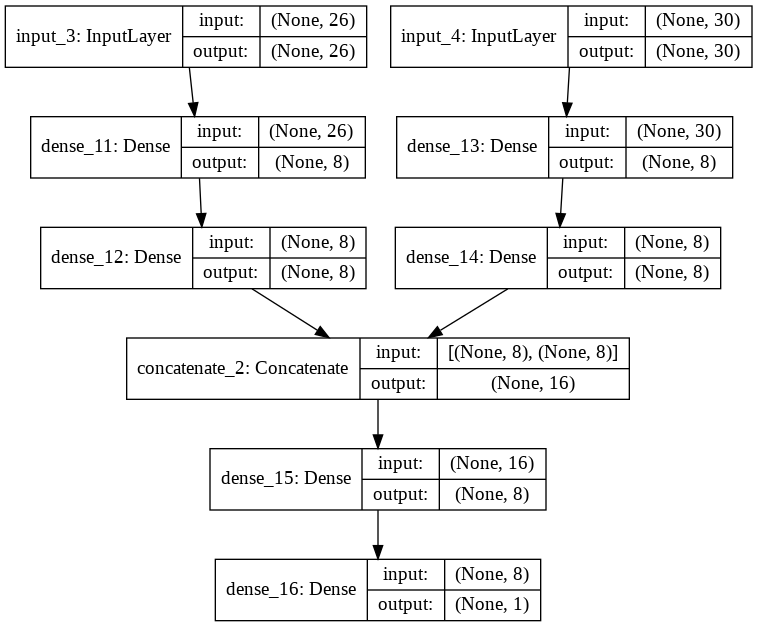

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [0]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 8)            216         input_3[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 8)            248         input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
xtrain_dl = scaling_pipeline.fit_transform(xtrain.copy())


In [0]:
model_output = model.fit([xtrain_dl.iloc[:,:26], xtrain_dl.iloc[:,26:]], ytrain, epochs=500, batch_size=20000, verbose=1, validation_split=0.2)

Train on 854803 samples, validate on 213701 samples
Epoch 1/500
854803/854803 [==============================] - 2s 2us/step - loss: 0.8464 - accuracy: 0.9564 - val_loss: 0.7004 - val_accuracy: 0.9630
Epoch 2/500
854803/854803 [==============================] - 2s 2us/step - loss: 0.6288 - accuracy: 0.9630 - val_loss: 0.5657 - val_accuracy: 0.9633
Epoch 3/500
854803/854803 [==============================] - 2s 2us/step - loss: 0.5182 - accuracy: 0.9653 - val_loss: 0.4717 - val_accuracy: 0.9687
Epoch 4/500
854803/854803 [==============================] - 2s 2us/step - loss: 0.4340 - accuracy: 0.9735 - val_loss: 0.3967 - val_accuracy: 0.9783
Epoch 5/500
854803/854803 [==============================] - 2s 2us/step - loss: 0.3665 - accuracy: 0.9823 - val_loss: 0.3365 - val_accuracy: 0.9858
Epoch 6/500
854803/854803 [==============================] - 2s 2us/step - loss: 0.3121 - accuracy: 0.9882 - val_loss: 0.2876 - val_accuracy: 0.9903
Epoch 7/500
854803/854803 [===========================

In [0]:
y_pred = model.predict([X_test_lite_2[X_test_lite_2.columns[:26]], X_test_lite_2[X_test_lite_2.columns[26:]]])
y_pred1 = np.array([round(x[0]) for x in y_pred], dtype="int64")
confusion_matrix(y_test_lite_2, y_pred1)

array([[205737,     45],
       [   862,   7057]])